## Week 11 Lecture 1

We want to study two approaches to extending liner models. We will add independent variables by

- taking polynomial transformations involving products of features or
- applying one-hot encoding to categorical data 


We will look at two examples. Building on the data about student scores from Week 10 Lecture 2, we will study the grades of students. 

In [218]:
# Importing packages

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 8)

import re

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression

### Example (Student Grades)

We want to study three possible datasets about student grades. We will investigate the pattens in the residuals to determine extensions of the linear model to better fit the data.

#### Multiple Independent Variables

Suppose we have the following table with student scores based on two assignments. Note the highest score is 25.

In [219]:
grades = pd.DataFrame(data = {
    "overall score": [21, 18, 24, 20, 23, 24, 21, 25, 22, 21],
    "points deducted homework 1" : [2, 4, 0, 2, 1, 1, 3, 0, 2, 0],
    "points deducted homework 2" : [2, 3, 1, 3, 1, 0, 1, 0, 1, 4]
})
grades

,overall score,points deducted homework 1,points deducted homework 2
0,21,2,2
1,18,4,3
2,24,0,1
3,20,2,3
4,23,1,1
5,24,1,0
6,21,3,1
7,25,0,0
8,22,2,1
9,21,0,4


Before we generate a scatter-plot we need to scale the data to have standard deviation 1.

In [220]:
score_std = np.std(grades["overall score"])
hw1_std = np.std(grades["points deducted homework 1"])
hw2_std = np.std(grades["points deducted homework 2"])

In [221]:
grades_scaled = grades.div([score_std, hw1_std, hw2_std])

We can us a scatter-plot to show the relationship between values. 

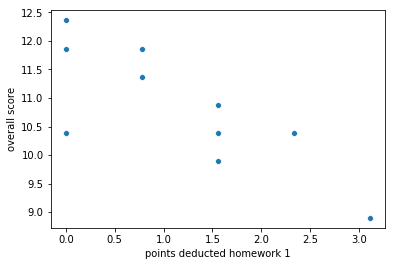

In [22]:
sns.scatterplot(grades_scaled["points deducted homework 1"], grades_scaled["overall score"]);

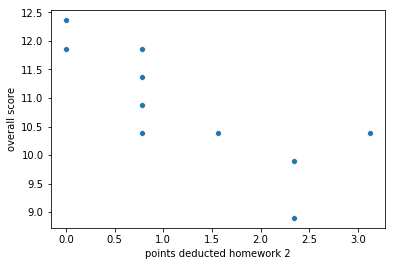

In [23]:
sns.scatterplot(grades_scaled["points deducted homework 2"], grades_scaled["overall score"]);

We can compute the correlation.

In [224]:
grades.corr()

,overall score,points deducted homework 1,points deducted homework 2
overall score,1.000000,-0.789133,-0.787674
points deducted homework 1,-0.789133,1.000000,0.243162
points deducted homework 2,-0.787674,0.243162,1.000000


We find that score and homework 1 has negative correlation. We find that score and homework 2 has negative correlation. However, the correlations are not equal to -1. Since the correlations are not equal to -1, we will have some differences between observed values and predicted values for any model that predicts score from homework 1 or score from homework 2. 

Let us determine the slopes for these models.

In [225]:
variance_hw1 = np.mean( (grades["points deducted homework 1"] - np.mean(grades["points deducted homework 1"]))**2 )
variance_hw2 = np.mean( (grades["points deducted homework 2"] - np.mean(grades["points deducted homework 2"]))**2 )

In [30]:
covariance_hw1 = np.mean( (grades["overall score"] - np.mean(grades["overall score"])) * (grades["points deducted homework 1"] - np.mean(grades["points deducted homework 1"])) )
covariance_hw2 = np.mean( (grades["overall score"] - np.mean(grades["overall score"])) * (grades["points deducted homework 2"] - np.mean(grades["points deducted homework 2"])) )

In [226]:
slope_hw1 = covariance_hw1 / variance_hw1
slope_hw2 = covariance_hw2 / variance_hw2

In [227]:
slope_hw1

-1.595922835531122

Let us determine the intercepts for these models.

In [228]:
intercept_hw1 = np.mean(grades["overall score"]) - slope_hw1 * np.mean(grades["points deducted homework 1"])
intercept_hw2 = np.mean(grades["overall score"]) - slope_hw2 * np.mean(grades["points deducted homework 2"])

We can plot both lines.

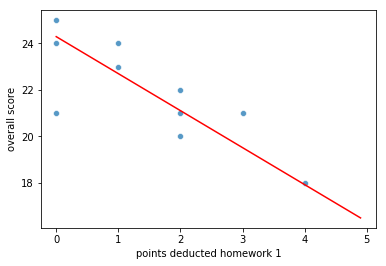

In [230]:
x_values = np.arange(0.0,5,0.1)

sns.scatterplot(grades["points deducted homework 1"], grades["overall score"], alpha = 0.75)
plt.plot(x_values, intercept_hw1 + slope_hw1 * x_values, 'r');

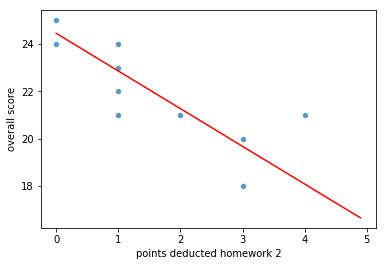

In [40]:
x_values = np.arange(0.0,5,0.1)

sns.scatterplot(grades["points deducted homework 2"], grades["overall score"], alpha = 0.75)
plt.plot(x_values, intercept_hw2 + slope_hw2 * x_values, 'r');

We know that $$\text{overall score} = 25 - \text{points deducted from homework 1} - \text{points deducted from homework 2}$$ So we should not expect a prediction from homework 1 or a prediction from homework 2 to make the observed score. We can check the residuals

In [231]:
grades["residuals homework 1"] = grades["overall score"] - (intercept_hw1 + slope_hw1 * grades["points deducted homework 1"])
grades["residuals homework 2"] = grades["overall score"] - (intercept_hw2 + slope_hw2 * grades["points deducted homework 2"])

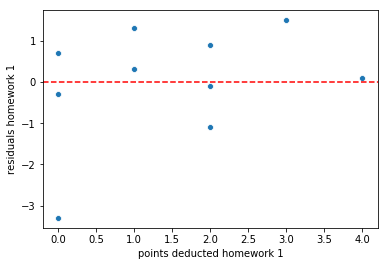

In [232]:
sns.scatterplot(grades["points deducted homework 1"], grades["residuals homework 1"])
plt.axhline(y = 0, color = "r", linestyle="--");

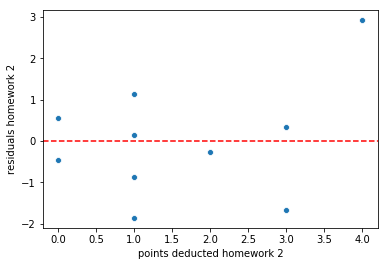

In [87]:
sns.scatterplot(grades["points deducted homework 2"], grades["residuals homework 2"])
plt.axhline(y = 0, color = "r", linestyle="--");

We need to have both independent variables in the model. We will use the scikit-learn package to determine the slopes and intercept for the model with both homework 1 and homework 2.

In [233]:
hw1_hw2_linear_model = LinearRegression().fit(grades[["points deducted homework 1", "points deducted homework 2"]], 
                                              grades["overall score"])

We obtains two slopes and one intercept.

In [234]:
slope = hw1_hw2_linear_model.coef_
slope

array([-1., -1.])

In [235]:
intercept = hw1_hw2_linear_model.intercept_
intercept

25.0

So the slopes and intercepts determined by linear regressin give predictions $$\widehat{\text{overall score}} = 25 - \text{points deducted from homework 1} - \text{points deducted from homework 2}$$ We know that $$\widehat{\text{overall score}} = \text{overall score}$$ We can make a plot in 3-dimensions to check that the predicted values match the observed values. 

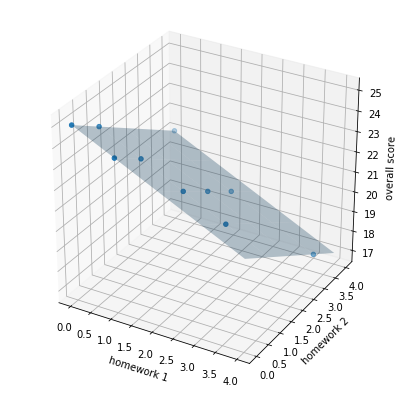

In [236]:
xvalue, yvalue = np.meshgrid(range(5), range(5))
zvalue = 25 - xvalue - yvalue

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(grades["points deducted homework 1"], grades["points deducted homework 2"], grades["overall score"], marker="o")
ax.plot_surface(xvalue, yvalue, zvalue, alpha=0.3)

ax.set_xlabel('homework 1')
ax.set_ylabel('homework 2')
ax.set_zlabel('overall score');

#### Interactions between Independent Variables

Suppose we have the following table with student scores and participation.

In [237]:
grades = pd.DataFrame(data = {
    "overall score": [1.74, 0.4 , 0.  , 1.54, 4.56, 0.07, 1.74, 4.95, 1.6 , 2.88],
    "points homework" : [2, 10, 0, 2, 6, 1, 3, 9, 2, 4],
    "attendance" : [0.87, 0.04, 0.51, 0.77, 0.76, 0.07, 0.58, 0.55, 0.8 , 0.72],
})
grades

,overall score,points homework,attendance
0,1.74,2,0.87
1,0.40,10,0.04
2,0.00,0,0.51
3,1.54,2,0.77
4,4.56,6,0.76
5,0.07,1,0.07
6,1.74,3,0.58
7,4.95,9,0.55
8,1.60,2,0.80
9,2.88,4,0.72


The student's score is the points for homework weighted by the attendance $$\text{overall score} = \text{points homework} * \text{attendance}$$ Here attendance is the fraction $$\text{attendance} = \displaystyle \frac{\text{classes attended}}{\text{classes held}}$$

We could try to use a linear model with the two independent variables $$\text{overall score} = a + b * \text{points homework} + c * \text{attendance}$$ 

In [238]:
hw_part_linear_model = LinearRegression().fit(grades[["points homework", "attendance"]], 
                                              grades["overall score"])

We obtains two slopes and one intercept.

In [239]:
slope = hw_part_linear_model.coef_
slope

array([0.36242876, 4.09643736])

In [240]:
intercept = hw_part_linear_model.intercept_
intercept

-1.7881521520725778

We can add the residuals to the dataset.

In [241]:
grades["residuals"] = grades["overall score"] - (intercept + slope[0] * grades["points homework"] +  slope[1] * grades["attendance"])

Plotting the residuals, we find that the observed values and the predicted values are different.

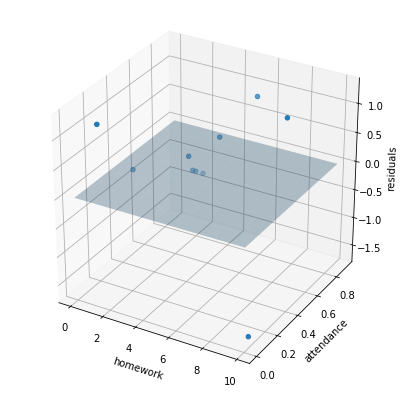

In [242]:
xvalue, yvalue = np.meshgrid(range(11), np.arange(0,1,0.1))
zvalue = np.zeros(xvalue.shape)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(grades["points homework"], grades["attendance"], grades["residuals"], marker="o")
ax.plot_surface(xvalue, yvalue, zvalue, alpha=0.3)

ax.set_xlabel('homework')
ax.set_ylabel('attendance')
ax.set_zlabel('residuals');

We can change the model. We want to add independent variables to capture homework, attendance and interaction between homework and attendance. While we can have different approaches to modelling interactions between the independent variables, an approach is to take the product $$\text{points homework} * \text{attendance}$$ We can include all products between the independent variables $$\text{points homework} * \text{homework}$$ $$\text{points homework} * \text{attendance}$$ $$\text{attendance} * \text{attendance}$$ We call these polynomial transformations.

In [244]:
grades["attendance squared"] = grades["attendance"]**2
grades["points homework squared"] = grades["points homework"]**2
grades["homework attendance"] = grades["points homework"] * grades["attendance"]

In [245]:
grades

,overall score,points homework,attendance,residuals,attendance squared,points homework squared,homework attendance
0,1.74,2,0.87,-0.760606,0.7569,4,1.74
1,0.40,10,0.04,-1.599993,0.0016,100,0.40
2,0.00,0,0.51,-0.301031,0.2601,0,0.00
3,1.54,2,0.77,-0.550962,0.5929,4,1.54
4,4.56,6,0.76,1.060287,0.5776,36,4.56
5,0.07,1,0.07,1.208973,0.0049,1,0.07
6,1.74,3,0.58,0.064932,0.3364,9,1.74
7,4.95,9,0.55,1.223253,0.3025,81,4.95
8,1.60,2,0.80,-0.613855,0.6400,4,1.60
9,2.88,4,0.72,0.269002,0.5184,16,2.88


We try again to fit the model to the data.

In [246]:
hw_part_linear_model = LinearRegression().fit(grades[['points homework', 'attendance', 'attendance squared','points homework squared', 'homework attendance']], 
                                              grades["overall score"])

We obtains two slopes and one intercept.

In [247]:
slope = hw_part_linear_model.coef_
slope

array([ 2.61801604e-16, -4.43083444e-16,  7.51908314e-16, -7.33637051e-16,
        1.00000000e+00])

In [248]:
intercept = hw_part_linear_model.intercept_
intercept

1.7541523789077473e-14

Note that the intercept is nearly 0 and the slopes are nearly 0 with the exception of the slope for `homework attendance`. Remember that the `homework attendance` column came from multiplying points on homework and attendance. So we obtain the predictions $$\widehat{\text{overall score}} = \text{points homework} * \text{attendance}$$ 

#### Qualitative Variables

Suppose we have the following table with student scores.

In [249]:
grades = pd.DataFrame(data = {
    "overall score": [ 2, 15,  5,  2,  6,  1,  3, 14,  7,  9],
    "homework 1" : [2, 10, 0, 2, 6, 1, 3, 9, 2, 4],
    "homework 2" : ['Fail', 'Pass', 'Pass', 'Fail', 'Fail', 'Fail','Fail', 'Pass', 'Pass','Pass'],
})
grades

,overall score,homework 1,homework 2
0,2,2,Fail
1,15,10,Pass
2,5,0,Pass
3,2,2,Fail
4,6,6,Fail
5,1,1,Fail
6,3,3,Fail
7,14,9,Pass
8,7,2,Pass
9,9,4,Pass


Here a student scores comes from homework 1 and homework 2. If students pass homework 2 then they receive 5 points. If students fail homework 2 then they receive 0 points. So we have 

$$\text{overall score} = \begin{cases} \text{homework 1} + 5 & \text{ if pass} \\ \text{homework 1} & \text{ if fail} \end{cases}$$

We can try to use linear regression. However, we must be careful about the values for homework 2. We need to convert these qualitative variables into quantitative variables. If we take an arbitrary encording then we might not have accurate predictions. 

For example, suppose we take the encoding $$\text{pass} \mapsto 10$$ $$\text{fail} \mapsto 20$$ 

In [251]:
def encoder(value):
    output = 20 
    
    if value == "Pass":
        output = 10
    
    return output

grades["homework 2 encoding"] = grades["homework 2"].map(encoder)
grades

,overall score,homework 1,homework 2,homework 2 encoding
0,2,2,Fail,20
1,15,10,Pass,10
2,5,0,Pass,10
3,2,2,Fail,20
4,6,6,Fail,20
5,1,1,Fail,20
6,3,3,Fail,20
7,14,9,Pass,10
8,7,2,Pass,10
9,9,4,Pass,10


We know that a student with 0 on homework 1 and a failing grade on homework 2 should have score 0. So we could use the model $$\widehat{\text{overall score}} = b * \text{homework 1} + c * \text{homework 2 encoding}$$ Here we fix $a = 0$. 

In [253]:
hw_encoding_linear_model = LinearRegression(fit_intercept=False).fit(grades[['homework 1', 'homework 2 encoding']], 
                                              grades["overall score"])

We obtains two slopes and one intercept.

In [254]:
slope = hw_encoding_linear_model.coef_
slope

array([ 1.50476725, -0.00701066])

In [255]:
grades["residuals"] = grades["overall score"] - (slope[0] * grades["homework 1"] +  slope[1] * grades["homework 2 encoding"])

Plotting the residuals, we find that the observed values and the predicted values are different.

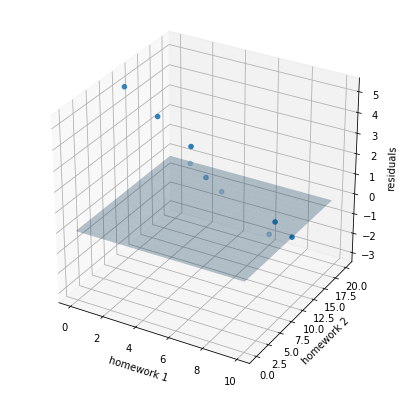

In [256]:
xvalue, yvalue = np.meshgrid(range(11), np.arange(0,20,1))
zvalue = np.zeros(xvalue.shape)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(grades["homework 1"], grades["homework 2 encoding"], grades["residuals"], marker="o")
ax.plot_surface(xvalue, yvalue, zvalue, alpha=0.3)

ax.set_xlabel('homework 1')
ax.set_ylabel('homework 2')
ax.set_zlabel('residuals');

In [258]:
grades = pd.DataFrame(data = {
    "overall score": [ 2, 15,  5,  2,  6,  1,  3, 14,  7,  9],
    "homework 1" : [2, 10, 0, 2, 6, 1, 3, 9, 2, 4],
    "homework 2" : ['Fail', 'Pass', 'Pass', 'Fail', 'Fail', 'Fail','Fail', 'Pass', 'Pass','Pass'],
})

grades = pd.get_dummies(data = grades, columns=["homework 2"])
grades

,overall score,homework 1,homework 2_Fail,homework 2_Pass
0,2,2,1,0
1,15,10,0,1
2,5,0,0,1
3,2,2,1,0
4,6,6,1,0
5,1,1,1,0
6,3,3,1,0
7,14,9,0,1
8,7,2,0,1
9,9,4,0,1


Note that we have added two columns. Think of 1 and 0 in terms of Yes and No. The column `homework 2_Fail` indicates 1 for Fail and 0 otherwise. The column `homework 2_Pass` indicates 1 for Pass and 0 otherwise. We can try again to fit the model.

In [259]:
hw_encoding_linear_model = LinearRegression(fit_intercept=False).fit(grades[['homework 1', 'homework 2_Fail', 'homework 2_Pass']], 
                                              grades["overall score"])

We obtains two slopes and one intercept.

In [261]:
slope = hw_encoding_linear_model.coef_
slope

array([1.00000000e+00, 6.44733171e-16, 5.00000000e+00])

In [262]:
grades["residuals"] = grades["overall score"] - (slope[0] * grades["homework 1"] + slope[1] * grades["homework 2_Fail"] + slope[2] * grades["homework 2_Pass"])

Now the residuals are 0.

In [263]:
grades

,overall score,homework 1,homework 2_Fail,homework 2_Pass,residuals
0,2,2,1,0,0.000000e+00
1,15,10,0,1,1.776357e-15
2,5,0,0,1,-1.776357e-15
3,2,2,1,0,0.000000e+00
4,6,6,1,0,8.881784e-16
5,1,1,1,0,-2.220446e-16
6,3,3,1,0,4.440892e-16
7,14,9,0,1,1.776357e-15
8,7,2,0,1,-8.881784e-16
9,9,4,0,1,0.000000e+00


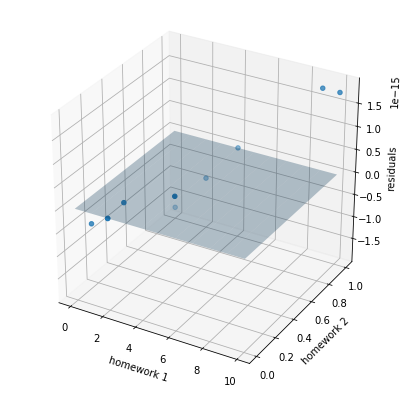

In [264]:
xvalue, yvalue = np.meshgrid(range(11), np.arange(0,2,1))
zvalue = np.zeros(xvalue.shape)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(grades["homework 1"], grades["homework 2_Pass"], grades["residuals"], marker="o")
ax.plot_surface(xvalue, yvalue, zvalue, alpha=0.3)

ax.set_xlabel('homework 1')
ax.set_ylabel('homework 2')
ax.set_zlabel('residuals');